# Before getting started

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# colors
c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

In [ ]:
# get xGASS catalog
!wget -O xGASS_representative_sample.csv https://www.dropbox.com/s/hd81uq75gsm6i0z/xGASS_representative_sample.csv

In [3]:
!ls

sample_data  xGASS_representative_sample.csv


In [4]:
!head xGASS_representative_sample.csv

GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,lgMstar,expAB_r,model_r,merr_r,ext_r,petrR50_r,petrR90_r,petrR50_z,lgmust,CINDX,INCL,NUVr,lgSFR_tot_median,SFR_best,SFRerr_best,SFRcase_best,HIsrc,HI_FLAG,xGASSDR,zHI,W50cor,lgMHI,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB
11834,101866,J000047.89+141639.1,750,52235,141,0.19954000000000002,14.27755,0.036180000000000004,159.2,10.709000000000001,0.340868,15.3202,0.003,0.1738,3.55,10.51,3.21,9.18,2.96,73.6,4.04,0.39566937,0.82985944,0.0,9,3,1,2,0.036162,359.0,9.603,-1.1059999999999999,0.0,0.49,158499,722887,1,1,0,11.9957,-3.651931
11892,101874,J000200.82+150132.1,751,52251,266,0.50344,15.02561,0.03573,157.2,10.539000000000001,0.8204469999999999,15.1594,0.0027,0.1331,3.37,9.96,3.12,9.05,2.96,35.7,5.66,-1.0588461,0.038697675,0.07982571,2,4,99,3,0.0,0.0,8.74,-1.7990000000000002,-99.0,0.634,159195,725451,1,1,0,12.0152,-3.9589133000000003
11825,101876,J000210.19+140810.3,750,52235,13,0.5

# Can we predict a galaxy's neutral hydrogen (HI) content?

## Examine data with `pandas`

In [15]:
df = pd.read_csv('xGASS_representative_sample.csv', index_col='GASS')

df.sample(5, random_state=42)

,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,lgMstar,...,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB
GASS,,,,,,,,,,,,,,,,,,,,,
108064,4399,J082607.43+212724.1,1927,53321,554,126.530991,21.456709,0.014968,64.8,9.562119,...,-0.082,0.0,2.343,82,1873986,0,70,0,13.9322,0.037653
3504,112859,J011823.44+133728.4,423,51821,46,19.597670,13.624570,0.038010,167.5,10.159000,...,-0.512,0.0,0.564,110777,379025,1,1,0,11.7834,-3.794999
112116,0,J125606.10+274041.1,2241,54169,236,194.025420,27.678110,0.016483,71.5,9.118738,...,-0.682,0.0,2.294,412092,2227797,1,1,0,0.0000,-99.000000
111013,6977,J115905.47+245920.2,2655,54184,435,179.772800,24.988960,0.013479,58.3,9.919288,...,-0.669,0.0,1.308,445,2322871,0,27,0,12.9880,-0.439150
52045,180412,J083836.42+173809.2,2276,53712,610,129.651800,17.635900,0.041480,183.3,10.174000,...,-0.403,0.0,0.564,404722,2201247,1,1,0,11.7755,-3.204295


## A very simplified glossary for xGASS

For more details, see the xGASS paper by [Catinella et al. (2018)](https://core.ac.uk/download/pdf/154748757.pdf).

These columns comprise the **features** (the inputs to our model), and the **label**  (what our model will predict).

### Observational quantities
- `zSDSS` - Optical redshift from SDSS spectroscopy
- `Dlum` - Luminosity distance in Mpc
- `model_r` - $r$-band model magnitude corrected for Galactic extinction (`ext_r`)
- `NUVr` - $NUV - r$ color corrected for extinction in magnitudes

### Derived shape quantities
- `expAB_r` - Axial ratio from exponential disk fit to $r$-band light
- `petrR50_r` - Radius containing 50% of the Petrosian $r$-band flux
- `lgmust` - Log stellar mass surface density in units of $M_\odot\ {\rm kpc}^{-2}$
- `CINDX` - Concentration index
- `INCL` - Galaxy inclination

### Derived physical properties
- `lgMstar` - Log stellar mass in units of $M_\odot$, based on MPA-JHU value-added SDSS catalogs
- `SFR_best` - Star formation rate in $M_\odot\ {\rm yr}^{-1}$
- `lgGF` - **Log gas/stellar mass fraction** i.e., what we want to predict

## Examine and clean features

Let's pick a few columns and see if we can combine them in order to predict the logarithmic HI gas-to-stellar mass fraction. Note that I *won't* use `lgMstar` or `lgmust` as features, since the stellar mass is a part of what we're trying to estimate! 

In [16]:
magnitude_features = ['model_r', 'NUVr']
morphological_features = ['expAB_r', 'petrR50_r', 'CINDX', 'INCL']

features = magnitude_features + morphological_features

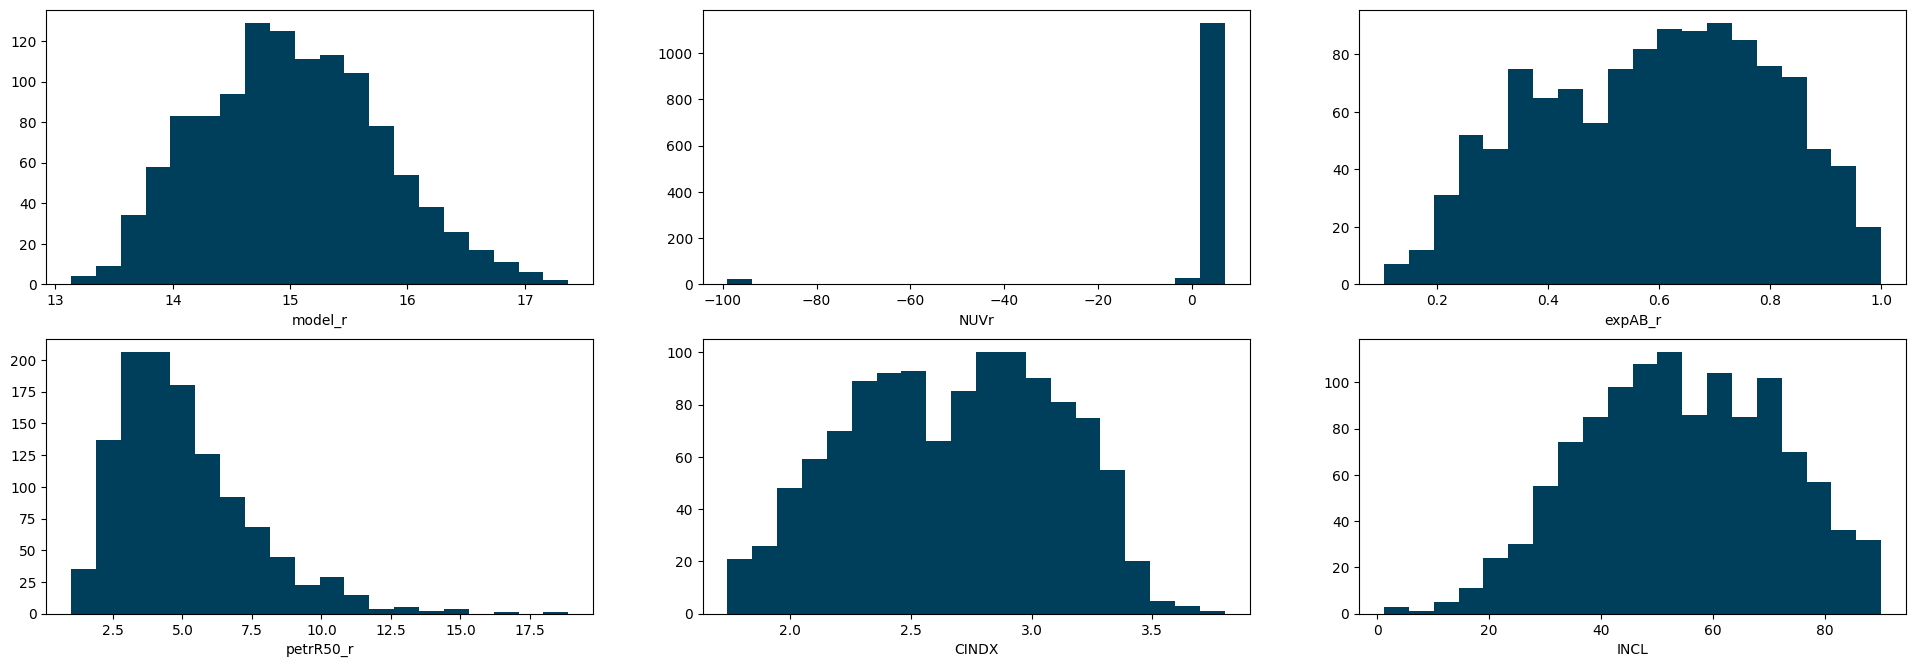

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(24, 8), dpi=100)

for feature, ax in zip(features, axes.flat):
    df[feature].plot.hist(bins=20, color=c0, ax=ax)
    ax.set(xlabel=feature, ylabel='')

fig.subplots_adjust()

A small amount of data cleaning: galaxies without $NUV-r$ colors?

In [18]:
sum(df.NUVr < -90), len(df)

(22, 1179)

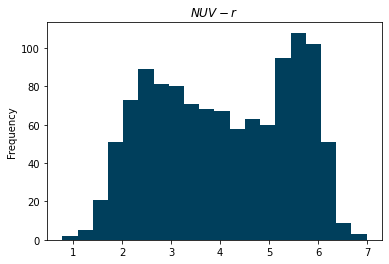

In [19]:
# remove galaxies with missing values
df = df[df.NUVr > -90].copy()

df.NUVr.plot.hist(bins=20, color=c0, title='$NUV - r$')

Let's also look at the depedent variable

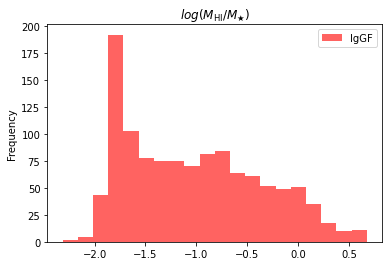

In [33]:
target = ['lgGF']

df[target].plot.hist(bins=20, color=c3, title=r'$log(M_{\rm HI}/M_\bigstar)$')

To summarize: here are the features, `X`, and the target, `y` (shown in red):

In [21]:
(
    df[features + target]
    .sample(5, random_state=42)
    .style.set_properties(
        **{'color': c3}, 
        subset=target
    )
)

,model_r,NUVr,expAB_r,petrR50_r,CINDX,INCL,lgGF
GASS,,,,,,,
38717,15.437700,2.830000,0.612988,5.040000,2.550000,53.700000,-0.687000
109057,15.010400,5.800000,0.762775,4.830000,3.050000,41.300000,-1.621000
4130,15.183700,5.610000,0.620971,3.540000,3.250000,53.100000,-1.801000
109097,13.964900,5.480000,0.286419,5.240000,2.650000,77.900000,-1.809000
51190,14.459100,3.690000,0.445285,5.660000,2.330000,66.000000,-0.997000


## Visualizing correlations

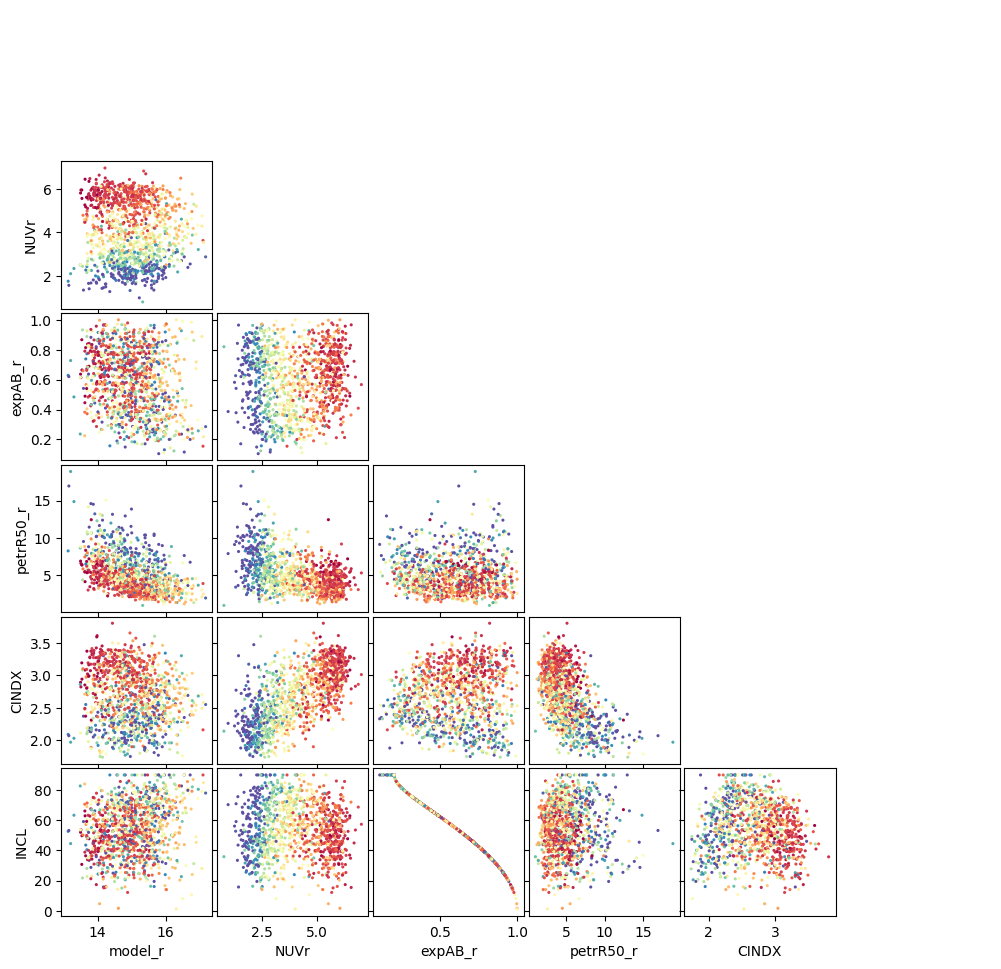

In [22]:
# plotting features, and letting the *color* represent the target (gas fraction)

fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12), dpi=100)


for i, col_y in enumerate(features):
    for j, col_x in enumerate(features):
        ax = axes[i ,j]

        if i <= j: 
            ax.axis('off')
        else: 
            ax.scatter(df[col_x], df[col_y], c=df[target].values, s=5, edgecolor='none', vmin=-2, vmax=0, cmap='Spectral')
        
        if i == len(features) - 1: 
            ax.set_xlabel(col_x)
        else:
            ax.set_xticklabels([])
        if j == 0: 
            ax.set_ylabel(col_y)
        else:
            ax.set_yticklabels([])


fig.subplots_adjust(wspace=0.03, hspace=0.03)

Looks like the inclination is simply the arctangent of the axial ratio. Also, $NUV-r$ color is strongly correlated with HI gas mass fraction (which is well-known, see e.g., Kannappan 2004).

<center><h2><i>Pause for questions</i></h2></center>

# Polynomial regression

## Multivariate Linear regression

So we have some features $X$, some targets $y$, and we want to make predictions $\hat y$ that are close to the true values ($y$). The easiest way to formulate this prediction problem is via a linear combination of features:
$$ \hat y = \vec A \cdot \vec x = A_1x_1 + A_2x_2 + \cdots + A_m x_m,$$

where $\vec x = (\rm model\_r, NUVr, expAB\_r, petrR50\_r, CINDX, INCL)$ are the **features**, $\vec A$ contains our model parameters (linear coefficients), and $y$ is our **target**, $\rm lgGF$. Here we have written it for a single galaxy example, but we can also generalize things to a whole sample of galaxies:
$$ \hat{y} = \mathbf{X} \vec{A}^T.$$

Due to linear algebra and blah blah this is uniquely solvable if something or other, whatever. Read the [Hogg et al. (2010) tutorial](https://arxiv.org/abs/1008.4686) if you're interested in all that, but I won't cover it here.

Remember that we've removed 22 galaxies with bad $NUV - r$ values. So we have data set with `n_samples` = 1155 galaxies, and we're considering `n_features` = 6 features. We should find that the shapes of these arrays in Python are:
```
y.shape is (n_samples, 1)
X.shape is (n_samples, n_features)
A.shape is (1, n_features)
```

Let's now write this model in code with `scikit-learn`!

In [71]:
y = df[target].values
X = df[features].values
print(f'y.shape is {y.shape}') 
print(f'X.shape is {X.shape}') 

y.shape is (1157, 1)
X.shape is (1157, 6)


In [72]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# this we are fitting the coefficients right now
model.fit(X, y)

LinearRegression()

In [73]:
A = model.coef_


print(f'A.shape is {A.shape}')
print(A)

A.shape is (1, 6)
[[ 0.19499454 -0.40462567 -0.68288805  0.06363814  0.27009117 -0.00607879]]


Hooray! Now we can look at the correlation coefficient $R^2$ to see how well we've recovered this relationship.

In [74]:
R2 = model.score(X, y)
R2

0.7872763889967059

In [75]:
# root mean squared error
def rmse(y, y_hat):
    return np.sqrt(((y - y_hat)**2).mean())

In [76]:
rmse(y, model.predict(X))

0.3066112657145414

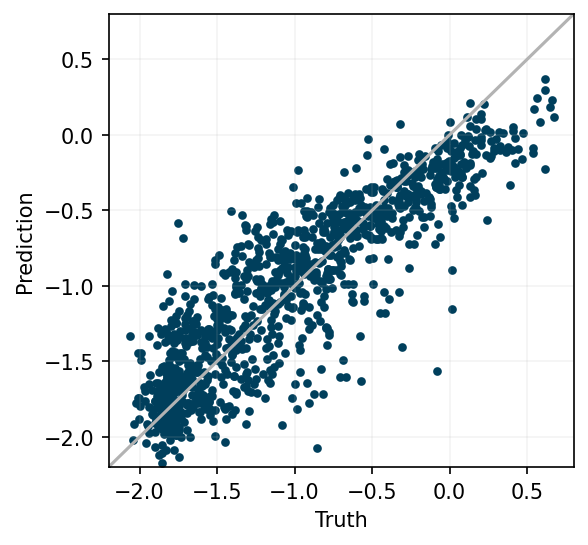

In [84]:
plt.figure(figsize=(4, 4), dpi=150)

plt.scatter(
    y, 
    model.predict(X),
    c=c0,
    s=10
)

plt.plot([-2.2, 0.8], [-2.2, 0.8], c='0.7')

plt.xlim(-2.2, 0.8)
plt.ylim(-2.2, 0.8)
plt.xlabel('Truth')
plt.ylabel('Prediction')

plt.grid(alpha=0.15)
plt.show()

## Train-test split

Not bad... but hang on. We're training and testing on the *same* data. Is this relationship generalizeable?

In order to find out, we will need to split our data into training and validation (and/or testing) subsets. Note that the word validation and test set can sometimes mean the same thing, depending on context! (This is just one of many frustrating things with machine learning jargon.)

I will use the following definitions:
- **Training**: The data used to update *model parameters* (e.g., coefficients or matrix element values).
- **Validation**: The data used to update *model selection* (for instance, we might change *hyperparameters* of a model based on the validation metrics).
- **Testing**: The data used to make final predictions, and possibly evaluate the final model score.

Not everybody uses these definitions! And sometimes you might see that there is no validation set because hyperparameters don't need to be adjusted. (What are hyperparameters anyway? We'll see later.)

I might also abbreviate these as train, valid, and test.

In [29]:
from sklearn.model_selection import train_test_split

# create a random split of 80% training, 20% validation/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(925, 6) (232, 6)


In this case, we've randomly reserved 20% of the data for testing, and kept 80% of the data for training the model. After training the model (i.e., determining the values for $\vec A$), we will check the $R^2$ score between the *model predictions* $\hat y_{\rm test} = \mathbf{X}_{\rm test} \vec A^T$ and the true *targets*, $y_{\rm test}$.

In [30]:
# re-initialize model
model = LinearRegression()

# fit model coefficients to training data
model.fit(X_train, y_train)

# evaluate on test data
R2 = model.score(X_test, y_test)
R2

0.7623030180856896

Now it's a bit lower, like $R^2 = 0.76$. To be sure that our result is robust, we can perform **cross-validation** (jargon alert!).

## Cross-validation

Here is a visual example of $k$-fold cross-validation, where $k$ = 5. Again we're seeing some iterchangeability between validation and test (also fold vs iteration). 
![](https://miro.medium.com/max/2736/1*rgba1BIOUys7wQcXcL4U5A.png)

Basically we take permutations of the test-train 80%-20% split until we are able to test on the entire data set, without directly training on any of the test subsets. This means that we need to reset our model between each iteration (or "fold").


In [31]:
from sklearn.model_selection import KFold, cross_validate

cv = cross_validate(
    estimator=LinearRegression(), 
    X=X, 
    y=y, 
    cv=5          # number of folds
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: 0.768 +/- 0.062


## Practice: Implement cross-validation and record RMSE metric

In [32]:
# Implement this ourselves and also report the root mean squared error (RMSE)

kf = KFold(5)

cv_scores = []
cv_rmse = []    

for train_index, test_index in kf.split(X):
    
    # FILL CODE IN 
    # Initialize and fit a sklearn LinearRegression model
    # Evaluate R^2 and RMSE scores and append below

    cv_scores.append( )   # FILL THIS IN
    cv_rmse.append( )     # FILL THIS IN

print(f'Cross-validated score: {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}')
print(f'Cross-validated RMSE:  {np.mean(cv_rmse):.3f} +/- {np.std(cv_rmse):.3f}')


Cross-validated score: 0.768 +/- 0.062
Cross-validated RMSE:  0.309 +/- 0.015


## Quadratic and higher-order polynomial models

So far we've been using the features in a linear model. What if we wanted a more complicated model?

Fortunately, we can modify the *features* to be polynomial versions of the original ones while keeping the model linear (since the model is just a bunch of coefficients).

A quadratic model would have corresponding coefficients to these new features:
$$ X = (x_1^2, x_1x_2, \cdots x_1x_m, x_2^2, x_2x_3, \cdots, x_m^2).$$


In [34]:
from sklearn.preprocessing import PolynomialFeatures

# linear model (adds bias term)
lin = PolynomialFeatures(degree=1)
X_lin = lin.fit_transform(X)

# quadratic model
quad = PolynomialFeatures(degree=2)
X_quad = quad.fit_transform(X)

print(X.shape, X_lin.shape, X_quad.shape)

(1157, 6) (1157, 7) (1157, 28)


Why does `X_lin` have an extra feature compared to `X`? This is because we are include a constant in there. It is always **1** because the coefficient is the y-intercept, also known as the **bias**. `X_quad` then has $7 \times 8 / 2 = 28$ terms, including combinations of all bias terms multiplied with the original features. And if we wanted a cubic model, we would find that `X_cubic` has $7 \times 8 \times 9 / (3!) = 84$ terms.

Given this exponential rise in number of parameters with the polynomial degree, we do not want to go too crazy with high-order polynomial models. They will become computationally expensive, and also will be in danger of **overfitting** (more on that below).

In [35]:
def k_fold_evaluate_polynomial(X, y, polynomial_degree=1, k=5):
    """Perform a k-fold cross-validation using a polynomial model.
    Prints R^2 and RMSE results. 
    """

    X_poly = PolynomialFeatures(degree=polynomial_degree).fit_transform(X)
    print(f'Evaluating model with polynomial degree {polynomial_degree} (with {X_poly.shape[1]} features).')

    # same cross-val loop as above
    kf = KFold(5)

    cv_scores = []
    cv_rmse = []    

    for train_index, test_index in kf.split(X_poly):
        X_train = X_poly[train_index]
        y_train = y[train_index]
        X_test = X_poly[test_index]
        y_test = y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        cv_scores.append(model.score(X_test, y_test))
        cv_rmse.append(rmse(y_test, model.predict(X_test)))

    print(f'    R^2:   {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}')
    print(f'    RMSE:  {np.mean(cv_rmse):.3f} +/- {np.std(cv_rmse):.3f}\n')

In [36]:
k_fold_evaluate_polynomial(X, y, polynomial_degree=1)
k_fold_evaluate_polynomial(X, y, polynomial_degree=2)
k_fold_evaluate_polynomial(X, y, polynomial_degree=3)
k_fold_evaluate_polynomial(X, y, polynomial_degree=4)


Evaluating model with polynomial degree 1 (with 7 features).
    R^2:   0.768 +/- 0.062
    RMSE:  0.309 +/- 0.015

Evaluating model with polynomial degree 2 (with 28 features).
    R^2:   0.795 +/- 0.053
    RMSE:  0.290 +/- 0.021

Evaluating model with polynomial degree 3 (with 84 features).
    R^2:   0.310 +/- 0.965
    RMSE:  0.446 +/- 0.311

Evaluating model with polynomial degree 4 (with 210 features).
    R^2:   -0.252 +/- 1.515
    RMSE:  0.632 +/- 0.384



## Overfitting

So, what does it mean to "overfit" a model? Well, a picture is worth a thousand words:

![](https://qph.fs.quoracdn.net/main-qimg-b4112b5d856f4f0da349460aeed854d8)

Although there is only a single feature here (or indepedent variable, $x$), we can intuitively understand why linear models might perform worse than low-order polynomials, and why low-order polynomials might outperform high-order polynomials!

Even in the example above, we saw that a cubic model isn't any better than a quadratic model. And if we try higher-order combinations of features, we'd get ridiculously bad results:


In [37]:
# 6th-order model -- BAD IDEA!
k_fold_evaluate_polynomial(X, y, polynomial_degree=6)


Evaluating model with polynomial degree 6 (with 924 features).
    R^2:   -2966.898 +/- 3391.419
    RMSE:  29.716 +/- 20.245



With a bit of work, we can visualize these models. For simplicity, though, we will only consider a model with two features (and polynomial combinations of them plus the bias term):
$$ X = (x_1, x_2, 1) = (\rm NUVr, petrR50\_r, 1),$$

so concretely, we could have polynomial models like:
$$ \hat y_{\rm linear} = A_1 x_1 + A_2 x_2 + A_3,$$
$$ \hat y_{\rm quadratic} = A_1 x_1^2 + A_2 x_1 x_2 + A_3 x_2^2 + A_4x_1 + A_5 x_2 + A_6,$$
etc.

In [38]:
X.shape

(1157, 6)

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_polynomial_model(deg):
    """Plot NUV-r color and Petrosian half-light radius as features for 
    estimating the log gas mass fraction. Show model based on training 
    data, and scatterplot points from the test data.
    """

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=150)
    ax.scatter(df['NUVr'], df['petrR50_r'], s=1, c='k', alpha=0.2)

    # create a grid of points to plot model results
    NUVr_min, NUVr_max = X[:, 1].min(), X[:, 1].max()
    petroR_min, petroR_max = X[:, 3].min(), X[:, 3].max()
    xx1, xx2 = np.meshgrid(np.linspace(NUVr_min, NUVr_max, 50), np.linspace(petroR_min, petroR_max, 50))

    # polynomial model on *training data*
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_poly = PolynomialFeatures(deg).fit_transform(X_train[:, (1, 3)])
    model = LinearRegression()
    model.fit(X_poly, y_train)

    # plot results from model
    X_grid = PolynomialFeatures(deg).fit_transform(np.c_[xx1.ravel(), xx2.ravel()])
    p = model.predict(X_grid).reshape(xx1.shape)
    ax.contourf(xx1, xx2, p, vmin=-2, vmax=0, levels=40, cmap='Spectral', alpha=.2)

    # compare with test set
    sc = ax.scatter(X_test[:, 1], X_test[:, 3], c=y_test, s=5, vmin=-2, vmax=0, cmap='Spectral')

    # colorbar + other axis details
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
    cbar.set_label('log gas mass fraction')

    ax.set_xlabel('$NUV-r$')
    ax.set_ylabel('$r$-band Petrosian half-light radius')

    ax.text(3, 17, f'Polynomial degree {deg}', fontsize=16)
    plt.show()

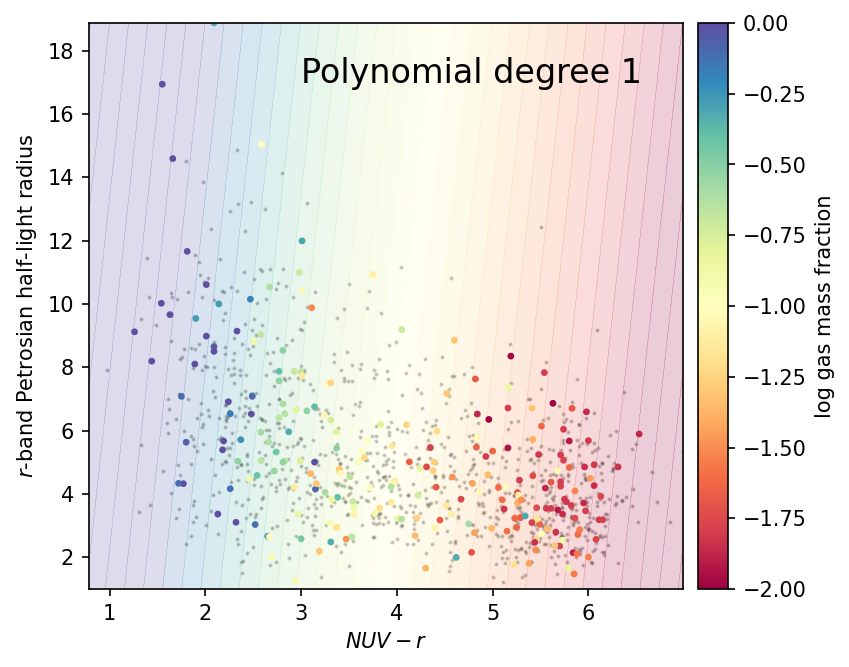

In [40]:
plot_polynomial_model(1)

To recap, this is a plot of two **features**, $NUV-r$ color (horizontal axis) and $r$-band half-light radius (vertical axis), against the **target**, log gas mass fraction. The log gas mass fraction is shown as colored markers for the *validation* set, and as small gray markers for the *training* set. Finally, our **model** is represented as the background color gradient, using the same colorscale as the data (see colorbar on right). Thus, you can read off model predictions based on the background color as a function of the position in the plot.

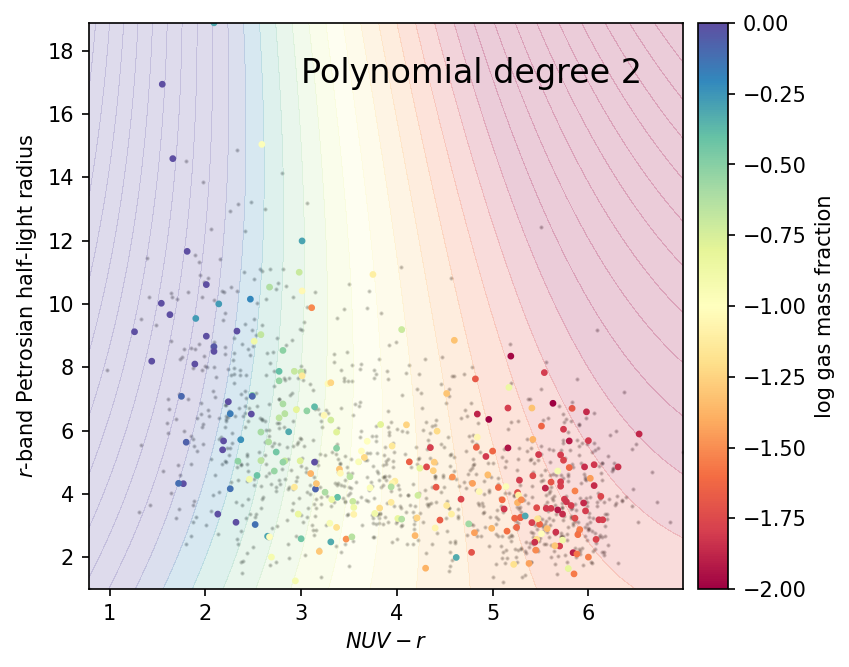

In [41]:
plot_polynomial_model(2)

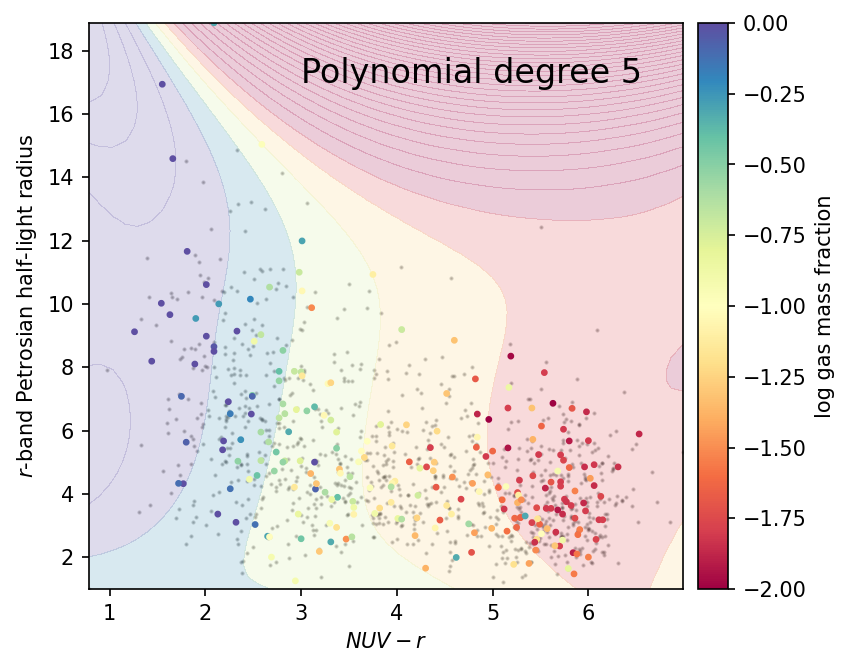

In [42]:
plot_polynomial_model(5)

This fifth-order polynomial model is pretty wiggly, and we're only doing it for *two* features. Now imagine how convoluted it would look if we used all *six* features... or even more!

# Decision trees



Another way to solve classification or regression problems is by using a ton of `if-else` statements. If you have a whole bunch of nested `if-else` statements, you have basically constructed a **decision tree**. See the image below for an example of a decision tree used in regression ([credit to the `dtreeviz` program](https://github.com/parrt/dtreeviz)).

![](https://mljar.com/blog/visualize-decision-tree/output_32_0.svg)

For our example, a very simple (hard-coded) decision tree might look something like this

In [43]:
def decision_tree_model(df):
    """Returns a log gas fraction based on decision tree 
    splits on features 'NUVr' and 'petrR50_r.
    """

    lgGF_predictions = []

    for row in df.itertuples():
        lgGF = -1.
        if row.NUVr < 4:
            lgGF += 0.8
            if row.petrR50_r > 5:
                lgGF += 0.3
            else:
                lgGF += -0.2
        else:
            lgGF += -0.75
        lgGF_predictions.append(lgGF)
    
    return np.array(lgGF_predictions)

Visualize our terrible model

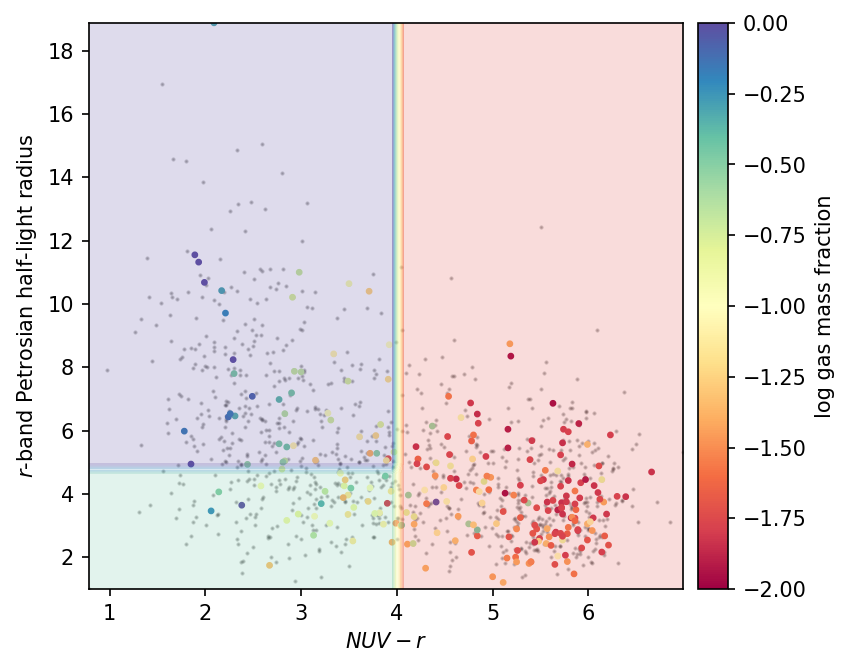

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=150)

# plot data
ax.scatter(df['NUVr'], df['petrR50_r'], s=1, c='k', alpha=0.2)
sc = ax.scatter(X_test[:, 1], X_test[:, 3], c=y_test, s=5, vmin=-2, vmax=0, cmap='Spectral')

# make grid
NUVr_min, NUVr_max = X[:, 1].min(), X[:, 1].max()
petroR_min, petroR_max = X[:, 3].min(), X[:, 3].max()
xx1, xx2 = np.meshgrid(np.linspace(NUVr_min, NUVr_max, 50), np.linspace(petroR_min, petroR_max, 50))

# plot results from decision tree
X_grid = pd.DataFrame(np.c_[xx1.ravel(), xx2.ravel()], columns=['NUVr', 'petrR50_r'])
p = decision_tree_model(X_grid).reshape(xx1.shape)
ax.contourf(xx1, xx2, p, vmin=-2, vmax=0, levels=40, cmap='Spectral', alpha=0.2, )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_label('log gas mass fraction')

ax.set_xlabel('$NUV-r$')
ax.set_ylabel('$r$-band Petrosian half-light radius');

## How scikit-learn does it

In [45]:
from sklearn.tree import DecisionTreeRegressor

In [48]:
# note that there are lots of "hyperparameters" for this model
# DecisionTreeRegressor?

In our examples above, the polynomial degree is an example of a **hyperparameter** - hyperparameters govern the structure of the model. 

For decision trees, we can see that there are lots of choices of hyperparameters: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, etc. These can alter the behavior of a decision tree greatly! Often times people will run decision trees (and other variants) with the default the hyperparameters; these can lead to extremely poor results and you should immediately be suspicious if there was no attempt made to optimize hyperparameters!

In [49]:
# only use the two features from above
X_train, X_test, y_train, y_test = train_test_split(X[:, [1, 3]], y, test_size=0.2, random_state=42)

In [50]:
# no hyperparameter tuning
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
print(dtree.score(X_test,  y_test))

0.5334722345642329


In [51]:
preds = dtree.predict(X_test)
print(f'RMSE = {rmse(y_test, preds):.4f}')

RMSE = 0.9271


In [52]:
def plot_tree_model(tree_model, label=None):
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=150)
    ax.scatter(df['NUVr'], df['petrR50_r'], s=1, c='k', alpha=0.2)

    # create a grid of points to plot model results
    NUVr_min, NUVr_max = X[:, 1].min(), X[:, 1].max()
    petroR_min, petroR_max = X[:, 3].min(), X[:, 3].max()
    xx1, xx2 = np.meshgrid(np.linspace(NUVr_min, NUVr_max, 50), np.linspace(petroR_min, petroR_max, 50))

    # plot results from decision tree
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    p = tree_model.predict(X_grid).reshape(xx1.shape)
    ax.contourf(xx1, xx2, p, vmin=-2, vmax=0, levels=40, cmap='Spectral', alpha=0.2, )

    # compare with test set
    sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5, vmin=-2, vmax=0, cmap='Spectral')

    # colorbar + other axis details
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
    cbar.set_label('log gas mass fraction')

    ax.set_xlabel('$NUV-r$')
    ax.set_ylabel('$r$-band Petrosian half-light radius')

    ax.text(1, 17, label, fontsize=16);

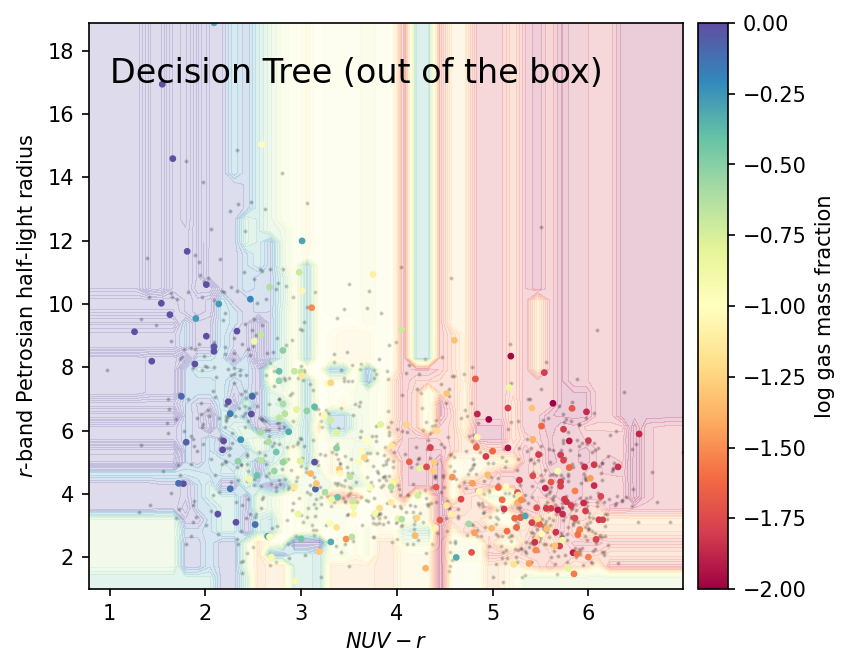

In [53]:
plot_tree_model(dtree, label=f'Decision Tree (out of the box)')

As you can see, overfitting can be a *nightmare* using a single decision tree.

## Random forests

Random forests take subsamples of the data and train many decision trees:
1. Randomly choose a subset of your training data and a subset of your training features (columns).
2. Train your model (decision tree) using this limited data.
3. Save the model, and then return to step 1 again with another random subset of the data; repeat.
4. Now you have multiple trained models. Predict with each of your models, and then average their outputs to get a final prediction.

Each decision tree model is not as good as if it had been trained using the entire data set, but the *ensemble* of these (uncorrelated) models can be much more powerful, and crucially, is more likely to be robust to outliers. 

Why? If your decision tree model makes random errors, and different models tend make different errors, then averaging these errors should tend toward zero!

In [54]:
from sklearn.ensemble import RandomForestRegressor

# again no hyperparameter
rf = RandomForestRegressor()
rf.fit(X_train, y_train.flatten())
rf.score(X_test, y_test.flatten())

0.706224078391255

In [55]:
preds = rf.predict(X_test)
print(f'RMSE = {rmse(y_test, preds):.4f}')

RMSE = 0.8840


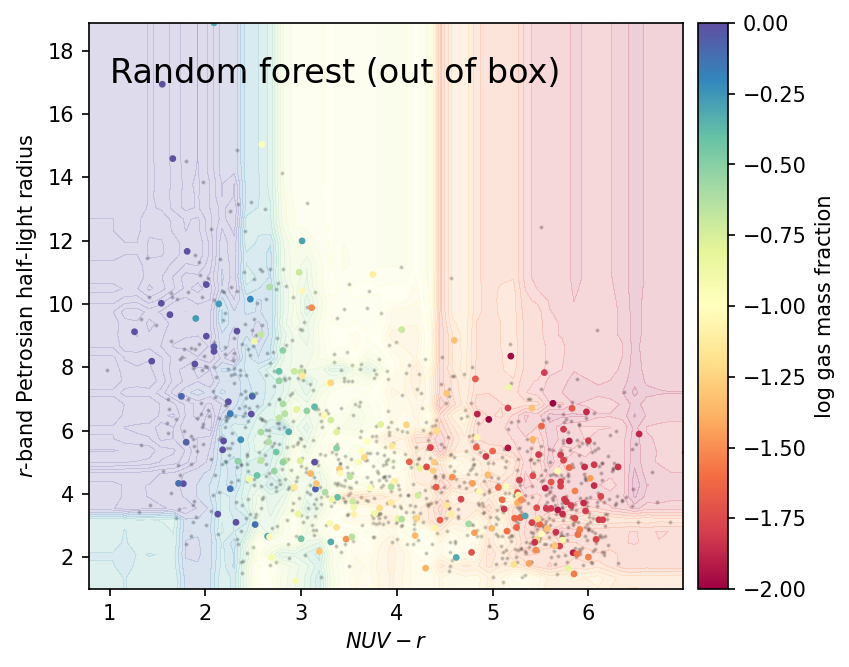

In [56]:
plot_tree_model(rf, label=f'Random forest (out of box)')

## Optimizing hyperparameters

There is a lot to be said about how to optimize model hyperparameters, and some of it can be found in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/grid_search.html). People often use a **grid search**, which involves choosing combinations of hyperparameters from some (prior, uninformative, ...) distribution. However, a **random search** can often be more efficient ([see example here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py))!

In [57]:
hyperparameter_distributions = {
    'n_estimators': np.arange(50, 300, 1).astype(int),
    'max_features': np.arange(0.1, 1, 0.05),
    'min_samples_leaf': np.arange(1, 10, 1).astype(int)
}

In [58]:
# Note this will likely take a few minutes
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=hyperparameter_distributions,
    n_iter=100
)

random_search.fit(X_train, y_train.flatten())

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80...
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 28

In [61]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(
                f"Mean validation score: {results['mean_test_score'][candidate]:.3f}" 
                f"(std: {results['std_test_score'][candidate]:.3f})"
            )
            print(f"Parameters: {results['params'][candidate]}")
            print("")

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.766(std: 0.024)
Parameters: {'n_estimators': 64, 'min_samples_leaf': 9, 'max_features': 0.9000000000000002}

Model with rank: 2
Mean validation score: 0.766(std: 0.024)
Parameters: {'n_estimators': 115, 'min_samples_leaf': 7, 'max_features': 0.8000000000000002}

Model with rank: 3
Mean validation score: 0.766(std: 0.025)
Parameters: {'n_estimators': 149, 'min_samples_leaf': 7, 'max_features': 0.15000000000000002}



Examine results

In [66]:
preds = random_search.predict(X_test)
print(f'RMSE = {rmse(y_test, preds):.4f}')

RMSE = 0.8630


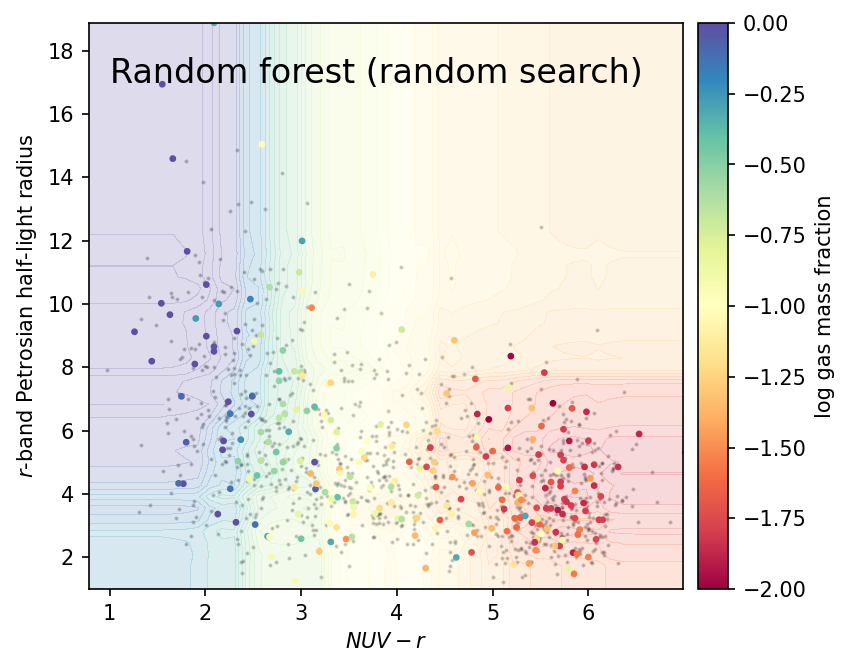

In [67]:
plot_tree_model(random_search, label=f'Random forest (random search)')

## Feature importances

We can examine the feature importances using a random forest model. Let's review what a single split in a decision tree looks like:

```python
def decision_tree_model(df):
    """Returns a log gas fraction based on single decision 
    tree split using features in `df`.
    """

    lgGF_predictions = []
    for row in df.itertuples():
        split = row['NUVr'] < 4
        if split:
            lgGF += 0.8
        else:
            lgGF += -0.75
        lgGF_predictions.append(lgGF)
    
    return np.array(lgGF_predictions)
```

At every split (aka `if`-`else` statement) in the tree, we can look at how much the model improved (and also look at which feature was used to make the split). The sum of all improvements at every split is used to compute each feature's **importance score**.

Let's use all 6 features again. 

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, min_samples_leaf= 5, max_features=0.9)
rf.fit(X_train, y_train.flatten())

RandomForestRegressor(max_features=0.9, min_samples_leaf=5, n_estimators=200)

In [69]:
y_pred = rf.predict(X_test)
rmse(y_test, y_pred)

0.8689168936580918

In [70]:
pd.DataFrame({
    'feature': features, 
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

,feature,importance
1,NUVr,0.824502
4,CINDX,0.059726
0,model_r,0.041026
3,petrR50_r,0.028551
2,expAB_r,0.024558
5,INCL,0.021636


Clearly we can see that the $NUV - r$ color is the most important feature!